### 1. import libraries 

In [1]:
import pandas as pd 
import numpy as np 
import torch 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader,random_split 

### 2. Set file_path 

In [2]:
file_path = "/home/rudgh1999/diabets/diabetes.csv"

### 3. Data preprocessing 

In [3]:
class CustomDataset(Dataset):
    def __init__(self,file_path):
        df = pd.read_csv(filepath_or_buffer=file_path)
        self.x = df.iloc[:,0:8].values 
        self.y = df.iloc[:,8:9].values
        self.length = len(df)

    def __getitem__(self,index):
        x = torch.FloatTensor(self.x[index])
        y = torch.FloatTensor(self.y[index])
        return x,y 
    
    def __len__(self):
        return self.length

### 4. Create Dataloader and load the data on the dataloader 

In [4]:
dataset = CustomDataset(file_path=file_path)
train_size = 0.8 
test_size = 0.2 
train_dataset, test_dataset = random_split(dataset,[train_size,test_size])

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=12,
                              num_workers=0,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=12,
                             num_workers=0,
                             shuffle=False)
len(train_dataset),len(train_dataloader)

(615, 52)

### 5. Let's build model 

In [5]:
class DiabetsModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(8,32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16,1),
            nn.Sigmoid(),
        )
    
    def forward(self,x):
        return self.layer(x)

### +++ Make accuracy function

In [6]:
# Accuracy function 
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

### 6. Let's set our optimizer and loss_fn 

In [7]:
model = DiabetsModel()
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.001)
# optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)


### 7. Let's training our Model

In [8]:

numepochs = 10
losses = torch.zeros(numepochs)

for epochi in range(numepochs):
    model.train()
    epochi_train_loss = 0
    epochi_train_acc = 0 
    for batch_idx,(x,y) in enumerate(train_dataloader):
        yhat = model(x)
        y_hat_labels = torch.round(yhat)
        loss = loss_fn(yhat,y)
        epochi_train_acc += accuracy_fn(y_true=y,
                          y_pred=(yhat>0.5).float())
        # print(batch_idx,acc)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epochi_train_loss += loss.item()
        losses[epochi] = loss
    epochi_train_loss /= len(train_dataloader)
    epochi_train_acc /= len(train_dataloader)
     
    # print(f"Epochi train loss:{epochi_train_loss:.5f}, Epochi train acc : {epochi_train_acc}")
    ### Testing 
    epochi_test_loss, epochi_test_acc = 0,0 
    model.eval()
    with torch.inference_mode():
        for X,y in test_dataloader:
            test_yhat = model(X)
            test_yhat_labels = torch.round(test_yhat)
            epochi_test_loss += loss_fn(test_yhat,y)
            epochi_test_acc += accuracy_fn(y_true=y,
                                           y_pred=(test_yhat>0.5).float())
        
        epochi_test_loss /= len(test_dataloader)
        epochi_test_acc /= len(test_dataloader)
    print(f"\nTrain loss: {epochi_train_loss:.5f} | Test loss: {epochi_test_loss:.5f}, Test acc: {epochi_test_acc:.2f} %\n")
            
            


    


        


Train loss: 0.74256 | Test loss: 0.66340, Test acc: 64.53 %


Train loss: 0.67309 | Test loss: 0.66486, Test acc: 66.88 %


Train loss: 0.65329 | Test loss: 0.66281, Test acc: 67.52 %


Train loss: 0.64619 | Test loss: 0.61775, Test acc: 67.52 %


Train loss: 0.64528 | Test loss: 0.64830, Test acc: 61.75 %


Train loss: 0.63238 | Test loss: 0.65773, Test acc: 68.16 %


Train loss: 0.62301 | Test loss: 0.66420, Test acc: 66.88 %


Train loss: 0.63715 | Test loss: 0.62294, Test acc: 66.88 %


Train loss: 0.63066 | Test loss: 0.62831, Test acc: 67.95 %


Train loss: 0.62411 | Test loss: 0.59068, Test acc: 70.73 %



### 8. Let's plot the loss curves and visualize 

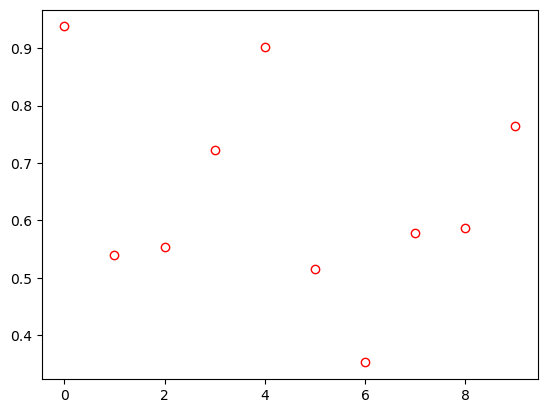

In [9]:
import matplotlib.pyplot as plt 
plt.plot(losses.detach(),"ro",markerfacecolor="w",linewidth=0.1)
plt.show()

In [18]:
from going_module import utils 
utils.save_model(model = model,
                 target_dir="models_d",
                 model_name="diabets_linear_model.pth")

[INFO] Saving model to : models_d/diabets_linear_model.pth
